# 3.1.1 BR

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.optimize import minimize
import statsmodels.formula.api as smf

sns.set_theme()

%load_ext autoreload
%autoreload 2

import estimation 
import logit
import data 

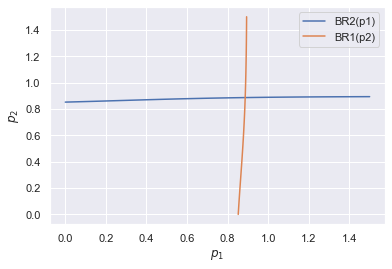

In [2]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Constants
c = 0.5
gamma = 1
alpha = 3

# Utility function
def v(j, p):
    if j == 0 or j-1 > len(p):
        return 0.
    else:
        return gamma - alpha * p[j-1]

# Demand function
def pr(j, p):
    v_values = [v(i, p) for i in range(len(p)+1)]
    v_exp = np.exp(v_values)
    return v_exp[j] / np.sum(v_exp)

# Market share function
def s(j, p):
    return pr(j, p)

# Profit function
def pi(j, p):
    p = np.array(p)  # Ensure p is always an array
    return (p[j-1] - c) * s(j, p)

def BR1(p2):
    f = lambda p1 : -pi(1, [p1[0], p2])
    res = optimize.minimize(f, [1], bounds=[(0, None)])
    p1 = res.x[0]
    return p1

def BR2(p1): 
    f = lambda p2 : -pi(2, [p1, p2[0]])
    res = optimize.minimize(f, [2], bounds=[(0, None)])
    p2 = res.x[0]
    return p2

# Generate prices
pp = np.linspace(0., 1.5, 100)
pp1 = np.empty(pp.shape)
pp2 = np.empty(pp.shape)
for i,p in enumerate(pp): 
    pp1[i] = BR1(p)
    pp2[i] = BR2(p)

# Plot best response functions
plt.plot(pp, pp2, label=f'BR2(p1)')
plt.plot(pp1, pp, label=f'BR1(p2)')
plt.legend(); 
plt.xlabel('$p_1$');
plt.ylabel('$p_2$');
plt.show()


# 3.1.1 NE

In [3]:
from scipy.optimize import fsolve

# Find Nash Equilibrium
def Nash(p):
    return [p[0] - BR1(p[1]), p[1] - BR2(p[0])]

p0 = [0, 0]  # Initial guess
p1, p2 = fsolve(Nash, p0)

print(f'Nash equilibrium prices: p1={p1}, p2={p2}')

Nash equilibrium prices: p1=0.886590839040838, p2=0.8865856229726662


# 3.1.2

In [4]:
def cartel_profit(p):
    p1, p2 = p
    return -(pi(1, [p1, p2]) + pi(2, [p1, p2]))

initial_guess = [0.5, 0.5]
bounds = [(0, None), (0, None)]
result = optimize.minimize(cartel_profit, initial_guess, bounds=bounds)

p1_cartel, p2_cartel = result.x

print(f'Cartel equilibrium prices: p1={p1_cartel}, p2={p2_cartel}')

Cartel equilibrium prices: p1=0.9409969693357556, p2=0.9409969644141133


# 3.1.3

In [5]:
def sequential_p1(p2): 
    f = lambda p1 : -pi(1, [p1[0], BR2(p1[0])])
    res = minimize(f, [1], bounds=[(0, None)])
    p1 = res.x[0]
    return p1

def sequential_p2(p1):
    f = lambda p2 : -pi(2, [p1, p2[0]])
    res = minimize(f, [2], bounds=[(0, None)])
    p2 = res.x[0]
    return p2

def sequential_equilibrium(init_p1=0.5, maxit=100, tol=1e-5): 
    p1 = init_p1
    for it in range(maxit): 
        p1_old = p1
        p2 = sequential_p2(p1)
        p1 = sequential_p1(p2)
        
        if np.abs(p1 - p1_old) < tol:
            print(f'Sequential equilibrium found after {it} iterations')
            break

    return p1, p2

p1_seq, p2_seq = sequential_equilibrium()
print(f'Sequential equilibrium prices: p1={p1_seq}, p2={p2_seq}')


Sequential equilibrium found after 1 iterations
Sequential equilibrium prices: p1=0.8887264446232453, p2=0.8866305584441647


# Likelihood

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.optimize import minimize
import statsmodels.formula.api as smf

sns.set_theme()

%load_ext autoreload
%autoreload 2

import estimation 
import logit
import data 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
cars = pd.read_csv('cars.csv')

In [8]:
cars.sample(3)

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,pop,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,inc,qu_tot,s
613,85,1,123,150,15,mazda 626,mazda,626,4,6,...,9860000,4834399879168,5.644800e+12,82039455744,9.579190e+10,8320.431641,9715.203125,26419.9529,283858,0.014007
4188,84,4,183,206,20,peugeot 305,peugeot,305,1,3,...,57000000,722810984988672,1.101367e+15,397628702720,6.058777e+11,6975.942383,10629.433594,26932.5195,1498062,0.005322
5681,92,5,18,17,3,BMW 3,BMW,3,2,4,...,58010000,598916005888,5.374480e+11,730755891200,6.557569e+11,12597.067383,11304.204102,25933.1597,1331538,0.021176


In [44]:
# some useful labels to better understand the data
labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']
# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()
dict_varnames

{'ye': 'year (=first dimension of panel)',
 'ma': 'market (=second dimension of panel)',
 'co': 'model code (=third dimension of panel)',
 'zcode': 'alternative model code (predecessors and successors get same number)',
 'brd': 'brand code',
 'type': 'name of brand and model',
 'brand': 'name of brand',
 'model': 'name of model',
 'org': 'origin code (demand side, country with which consumers associate model)',
 'loc': 'location code (production side, country where producer produce model)',
 'cla': 'class or segment code',
 'home': 'domestic car dummy (appropriate interaction of org and ma)',
 'frm': 'firm code',
 'qu': 'sales (number of new car registrations)',
 'cy': 'cylinder volume or displacement (in cc)',
 'hp': 'horsepower (in kW)',
 'we': 'weight (in kg)',
 'pl': 'places (number, not reliable variable)',
 'do': 'doors (number, not reliable variable)',
 'le': 'length (in cm)',
 'wi': 'width (in cm)',
 'he': 'height (in cm)',
 'li1': 'measure 1 for fuel efficiency (liter per km, 

# Pandas to Numpy

In [10]:
J = 40 # car types 
T = 30 # years (1970-1999)
M = 5  # markets 

In [56]:
controls = ['home', 'hp', 'we', 'li', 'cy', 'le'] # x variables 
dummyvar = ['brd','cla'] # fixed effects for brands and car classes

x,y,x_vars = data.get_x_y(cars, control_vars=controls, dummyvarlist=dummyvar)
N,J,K = x.shape
idx_price = 0 # price is the first variable in x (along 3rd dimension)

K = 46 variables selected.


# Estimate

In [57]:
thetahat, se = estimation.estimate_m(logit, y, x, method='BFGS', cov_type='Sandwich', 
                                     options={'disp':True, 'maxiter':10_000},
                                     tol=1e-8)

         Current function value: 3.463085
         Iterations: 468
         Function evaluations: 23171
         Gradient evaluations: 493


In [58]:
# print estimates
tab = pd.DataFrame({'Est':thetahat, 'se': se}, index = x_vars)
tab

,Est,se
p,-1.343312,0.116045
home,1.356426,0.031431
hp,-0.006338,0.001876
we,0.001002,0.000174
li,-0.054805,0.015596
cy,-0.000005,0.000009
le,-0.001566,0.000918
brd=2,0.704406,0.065408
brd=3,0.811006,0.080043
brd=4,0.261941,0.054878


# Selecting country-year

Selecting Germany in 1999. 

In [59]:
country = 'Germany'
year = 99
I = (cars['ma'].map(dict_ma) == country) & (cars['ye'] == year)

In [60]:
# select the rows of the dataset that corresponds to I 
market_data = cars.loc[I].reset_index()

In [61]:
# information about Germany in 1999 
population = market_data['pop'].unique()[0]
gdp = market_data['ngdp'].unique()[0]
gdp_per_capita = gdp / population
print(f'{country} has {population:,} people and {gdp:,} GDP in {year}')

Germany has 82,020,000 people and 3,849,660,137,472 GDP in 99


Create `x`: The matrix of regressors for Germany in 1999. It is $1 \times J \times K$, where 

* 1 = number of markets (there is just one) 
* $J = 40$ = number of available cars 
* $K = $ number of regressors in the logit demand model

In [62]:
# to predict market shares, we need a matrix of car characteristics for all cars available in Germany in 1999
idx = cars.loc[I].index.values
x = x.reshape(N*J,K)[idx,:].reshape(1,J,K)

# later we will need a function for changing the price in the x-matrix used by the logit functions
def set_car_price(x, p:float, j:int) -> None:
    # writes to the input!  
    x[:,j,idx_price] = p/gdp_per_capita # in the model, price is relative to gdp per capita


# Product-level competition

In [63]:
j1 = 22 # car type 1
j2 = 34 # car type 2 

# let's print some details about the selected variables 
cols = ['type', 'brand', 's', 'qu', 'pr', 'we', 'hp', 'li1']
market_data.loc[[j1,j2], cols].rename(columns=dict_varnames)

,name of brand and model,name of brand,market share (qu / qu_tot),sales (number of new car registrations),price (in destination currency including V.A.T.),weight (in kg),horsepower (in kW),"measure 1 for fuel efficiency (liter per km, at 90 km/h)"
22,volkswagen passat,VW,0.050595,136575,37800.0,1230,74.0,6.1
34,ford focus,ford,0.041837,112933,25850.0,1070,55.0,5.2


In [64]:
# predict market shares in the baseline 
s = logit.choice_prob(thetahat, x)

# print it and compared to observed market shares 
pd.DataFrame({'Market share, data': market_data.loc[[j1,j2], 's'].values, 'Market share, model': s[0,[j1,j2]]}, 
index = market_data.loc[[j1,j2], 'type'].values)

,"Market share, data","Market share, model"
volkswagen passat,0.050595,0.036229
ford focus,0.041837,0.046936


## The payoff functions

In [76]:
p1_data = market_data.loc[j1, 'pr'] # raw sticker price of the car in the data 
p2_data = market_data.loc[j2, 'pr'] # ... for car 2 

# we assume that marginal cost is 50% of the sticker price.... 
c1 = 0.5 * p1_data
c2 = 0.5 * p2_data

def market_shares(p1, p2): 
    x2 = x.copy() # copy to avoid writing to the original data 
    set_car_price(x2, p1, j1) # set the price of car j1 to the p1 (measured in the model's units)
    set_car_price(x2, p2, j2) # ... for car j2
    ccp = logit.choice_prob(thetahat, x2)
    s1 = ccp[0,j1] 
    s2 = ccp[0,j2] 
    return s1, s2

def profit(p, s, c): 
    # profit = Q * (p-c)
    return population * s * (p - c) / 1_000_000_000 # in 100 million EUR

def profit1(p1, p2): 
    s1, s2 = market_shares(p1, p2)
    pi1 = profit(p1, s1, c1)
    return pi1

def profit2(p2, p1): # note the order of inputs!!
    s1, s2 = market_shares(p1, p2)
    pi2 = profit(p2, s2, c2)
    return pi2

In [77]:
print(f'Baseline predicted profit for car {j1} ({market_data.loc[j1,"type"]}): {profit1(p1_data, p2_data):,.1f} million EUR')
print(f'Baseline predicted profit for car {j2} ({market_data.loc[j2,"type"]}): {profit2(p2_data, p1_data):,.1f} million EUR')

Baseline predicted profit for car 22 (volkswagen passat): 56.2 million EUR
Baseline predicted profit for car 34 (ford focus): 49.8 million EUR


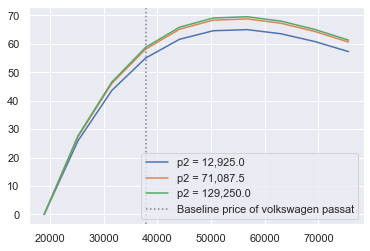

In [78]:

# printing the profit function for three values of the competitor price 
pp1 = np.linspace(0.5,2.,10) * p1_data
pp2 = np.linspace(0.5,5.,3) * p2_data
pi1 = np.empty((pp1.size,pp2.size))
for i2,p2 in enumerate(pp2): 
    for i1,p1 in enumerate(pp1): 
        pi1[i1,i2] = profit1(p1, p2)

    plt.plot(pp1, pi1[:,i2], label=f'p2 = {p2:,}')
plt.axvline(p1_data,color='gray',linestyle=':', label=f'Baseline price of {market_data.loc[j1,"type"]}')
plt.legend(); 

***... continue from here ...***

# 3.2.1

In [79]:
# Best response function for firm 1
def BR1(p2):
    f = lambda p1 : -profit1(p1, p2)
    res = minimize(f, p1_data, bounds=[(0, None)], method='Nelder-Mead')
    p1 = res.x[0]
    return p1

# Best response function for firm 2
def BR2(p1):
    f = lambda p2 : -profit2(p2, p1)
    res = minimize(f, p2_data, bounds=[(0, None)], method='Nelder-Mead')
    p2 = res.x[0]
    return p2

def system(p):
    p1, p2 = p
    return BR1(p2) - p1, BR2(p1) - p2

p_initial_guess = np.array([p1_data, p2_data])
p_Nash = fsolve(system, p_initial_guess)

p1_Nash, p2_Nash = p_Nash
print(f"Nash equilibrium prices: p1={p1_Nash}, p2={p2_Nash}")


Nash equilibrium prices: p1=54670.12580383598, p2=48771.341027552204


# 3.2.2

In [81]:
from scipy.optimize import minimize

# Joint profit
def joint_profit(p):
    p1, p2 = p
    return -(profit1(p1, p2) + profit2(p2, p1))

# Initial guess
p0 = np.array([p1_data, p2_data])

# Run the BFGS optimizer
res = minimize(joint_profit, p0, method='BFGS')

# Get the optimal prices
p1_cartel, p2_cartel = res.x

# Print the optimal prices
print(f"Cartel's optimal prices: p1={p1_cartel}, p2={p2_cartel}")


Cartel's optimal prices: p1=54971.36764716842, p2=49011.10807245255


# Brand-level competition

From here on, we instead look at competition across brands, rather than individual cars. 

At the brand-level, for example VW has 5 cars in Germany in 1999, so it sets 5 prices. To simplify matters, let us assume that VW only considers setting a single of those 5 prices, so that it scales all of its prices linearly, i.e. it chooses a single scalar, $p \ge 0$, which then scales all of its five prices: 

$$
\begin{align*}
P_{\text{polo}}  = p P_{\text{polo}}^{\text{data}}     \\
P_{\text{golf}}  = p P_{\text{golf}}^{\text{data}}     \\
P_{\text{pasat}} = p P_{\text{pasat}}^{\text{data}}   \\
P_{\text{lupo}}  = p P_{\text{lupo}}^{\text{data}}     \\
P_{\text{bora}}  = p P_{\text{bora}}^{\text{data}}     \\
\end{align*}
$$

So if it chooses $p = 1.0$, it gets the prices from the data (the baseline). 

In [82]:
# Choosing the two brands
brand1 = 'VW'
brand2 = 'opel'
I1 = market_data.brand == brand1
I2 = market_data.brand == brand2

# printing some data 
market_data.loc[I1 | I2, cols]

,type,brand,s,qu,pr,we,hp,li1
11,opel corsa,opel,0.041575,112226,17990.0,865,40.0,4.6
12,opel vectra,opel,0.034859,94096,35270.0,1215,74.0,5.8
13,opel omega,opel,0.010491,28318,50150.0,1460,106.0,7.1
14,opel astra,opel,0.085288,230224,25585.0,1035,48.0,5.0
20,volkswagen polo,VW,0.034536,93226,20800.0,880,37.0,4.9
21,volkswagen golf,VW,0.116060,313289,26900.0,1090,55.0,5.3
22,volkswagen passat,VW,0.050595,136575,37800.0,1230,74.0,6.1
38,volkswagen lupo,VW,0.022608,61026,18450.0,895,37.0,4.8
39,volkswagen bora,VW,0.015699,42378,33100.0,1185,74.0,6.0


In [83]:
s = logit.choice_prob(thetahat, x) # predicted market shares, (1, J)-array
pd.DataFrame({'Market share, data': [market_data.loc[I1].s.sum(), market_data.loc[I2].s.sum()],
              'Market share, pred': [s[0,I1].sum(), s[0,I2].sum()]
              }, index=[brand1,brand2])

,"Market share, data","Market share, pred"
VW,0.239499,0.250645
opel,0.172212,0.142644


## Payoff functions

In [84]:
p_data = market_data['pr'].values.copy() # prices of all cars 

# assumes that mc is half of the price 
c = 0.5 * p_data # J-vector

def market_shares(p): 
    x2 = x.copy() # copy to avoid writing to the original data
    for j in range(J): 
        set_car_price(x2, p[j], j)
    s = logit.choice_prob(thetahat, x2)
    return s[0,:] # since x2.shape[0]==1, we can just take the first row

def price_vec(p1, p2) -> np.ndarray: 
    p = p_data.copy() # important to copy, otherwise we modify the original array
    p[I1] *= p1*1.1 # scales p1 price
    p[I2] *= p2 # ... for brand2 
    return p 

def profit(p1, p2) -> np.ndarray: 
    '''returns a J-dimensional array of profits'''
    p = price_vec(p1, p2)
    s = market_shares(p)
    pi = population * s * (p - c) / 1_000_000_000 # in million
    return pi

def profit1(p1, p2) -> float: 
    '''
    Inputs: 
        p1,p2 are relative, so p1=1.0 sets all brand1 prices = baseline value,
        while p1=1.1 increases all brand1 prices by 10%
    '''
    pi = profit(p1, p2)
    pi1 = pi[I1].sum()
    return pi1

def profit2(p1, p2) -> float: 
    pi = profit(p1, p2)
    pi2 = pi[I2].sum()
    return pi2


In [85]:
print(f'Baseline profit to {brand1}: {profit(1.0, 1.0)[j1]:5.2f} million EUR')
print(f'Baseline profit to {brand2}: {profit(1.0, 1.0)[j2]:5.2f} million EUR')

Baseline profit to VW: 61.58 million EUR
Baseline profit to opel: 50.66 million EUR


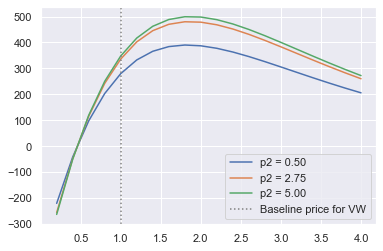

In [86]:
pp1 = np.linspace(0.2,4.,20) * 1.0
pp2 = np.linspace(0.5,5,3) * 1.0
pi1 = np.empty((pp1.size,pp2.size))
for i2,p2 in enumerate(pp2): 
    for i1,p1 in enumerate(pp1): 
        pi1[i1,i2] = profit1(p1, p2)

    plt.plot(pp1, pi1[:,i2], label=f'p2 = {p2:.2f}')
plt.axvline(1.0, color='gray', linestyle=':', label=f'Baseline price for {brand1}')
plt.legend(); 


***... continue from here...***

# 3.2.3.1

In [40]:
from scipy.optimize import minimize

# Best response function for firm 1
def BR1(p2):
    f = lambda p1: -profit1(p1, p2)
    res = minimize(f, 1.0, bounds=[(0, None)], method='Nelder-Mead')
    p1 = res.x[0]
    return p1

# Best response function for firm 2
def BR2(p1):
    f = lambda p2: -profit2(p1, p2)
    res = minimize(f, 1.0, bounds=[(0, None)], method='Nelder-Mead')
    p2 = res.x[0]
    return p2

# Solve for Nash equilibrium prices
p1_Nash = BR1(p2_data)
p2_Nash = BR2(p1_Nash)

print(f"Nash equilibrium prices: p1={p1_Nash}, p2={p2_Nash}")

Nash equilibrium prices: p1=1.9445312500000023, p2=1.8535156250000018


# 3.2.3.2

In [43]:
from scipy.optimize import minimize

# Joint profit function for the cartel
def joint_profit(p):
    pi = profit(p[0], p[1])
    return -pi.sum()

# Solve for Nash equilibrium prices assuming a cartel
res = minimize(joint_profit, [1.0, 1.0], bounds=[(0, None), (0, None)], method='Nelder-Mead')
p_Nash = res.x

p1_Nash, p2_Nash = p_Nash
print(f"Nash equilibrium prices (cartel): p1={p1_Nash}, p2={p2_Nash}")

Nash equilibrium prices (cartel): p1=2.5719707027711918, p2=2.6769443744680923
